Mainly an effort to try to reproduce this notebook (https://github.com/desihub/desisim/blob/master/doc/nb/bgs-reference-spectra.ipynb) in order to use the DESI pipeline for the project. Eventually the goal is to also reproduce this notebook: https://github.com/desihub/desisim/blob/master/doc/nb/bgs-redshift-efficiency.ipynb. 

In [1]:
import os
os.environ['DESI_BASIS_TEMPLATES']='/Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3'
import sys
import numpy as np 
from astropy.table import vstack
from scipy.spatial import cKDTree as KDTree
# --local--
from speclite import filters
from desimodel.io import load_throughput
from desisim.io import empty_metatable
from desisim.io import read_basis_templates
from desisim.templates import BGS
import desitarget.mock.quicksurvey as mockio
from desitarget.cuts import isBGS_bright, isBGS_faint

In [2]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2

In [3]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [4]:
simseed = 123
simrand = np.random.RandomState(simseed)

In [5]:
mockfile = '/Volumes/chang_eHDD/projects/desi/mocks/bgs/MXXL/desi_footprint/v0.0.4/BGS_r20.6.hdf5'
mockdata = mockio.read_durham_mxxl_hdf5(mockfile, rand=simrand, nside=32, nproc=nproc,
                                        healpixels=[3151,3150,3149,3148])

INFO:quicksurvey.py:1472:read_durham_mxxl_hdf5: Assigning healpix pixels with nside = 32
INFO:quicksurvey.py:1482:read_durham_mxxl_hdf5: Trimmed to 38857 BGSs in healpixels [3151, 3150, 3149, 3148]


In [6]:
mockdata['VDISP'] = np.repeat(100.0, len(mockdata['RA'])) # [km/s]

In [9]:
mockdata

{'BRICKNAME': array([u'3249p165', u'3264p157', u'3265p192', ..., u'3248p160',
        u'3244p165', u'3263p160'],
       dtype='<U8'),
 'DEC': array([ 16.40729713,  15.77822304,  19.16472244, ...,  15.89919853,
         16.44275475,  15.99462128]),
 'FILES': ['/Volumes/chang_eHDD/projects/desi/mocks/bgs/MXXL/desi_footprint/v0.0.4/BGS_r20.6.hdf5'],
 'FILTERNAME': 'sdss2010-r',
 'MAG': array([ 19.50129318,  20.36178017,  19.63550758, ...,  20.49723053,
         20.29958153,  19.70456696], dtype=float32),
 'MOCKID': array([36929249, 36929507, 36929597, ..., 41560733, 41560748, 41561506]),
 'N_PER_FILE': [41561531],
 'OBJID': array([36929249, 36929507, 36929597, ..., 41560733, 41560748, 41561506]),
 'RA': array([ 324.83517456,  326.50918579,  326.5640564 , ...,  324.72433472,
         324.43347168,  326.44470215]),
 'SDSS_01gr': array([ 0.93379325,  0.59651941,  1.00041103, ...,  0.72762054,
         0.96443969,  0.35007194], dtype=float32),
 'SDSS_absmag_r01': array([-20.52145767, -20.8831

(14.5, 19.5)

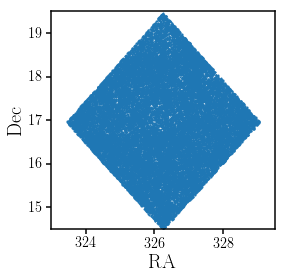

In [10]:
fig = plt.figure(figsize=(4,4)) 
sub = fig.add_subplot(111)
sub.scatter(mockdata['RA'], mockdata['DEC'], s=1)
sub.set_xlabel('RA', fontsize=20)
sub.set_xlim([323, 329.5])
sub.set_ylabel('Dec', fontsize=20)
sub.set_ylim([14.5, 19.5])

In [11]:
bgs_meta = read_basis_templates(objtype='BGS', onlymeta=True)

INFO:io.py:1015:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits metadata.


In [14]:
for k in bgs_meta.keys():
    print k, bgs_meta[k].data[:5]

TEMPLATEID [0 1 2 3 4]
PASS [304 304 304 304 416]
APER [218 283 281 215 180]
RA [ 216.56916   216.635505  216.615225  216.524355  216.796665]
DEC [ 32.642522  32.642946  32.645138  32.645616  32.658003]
Z [ 0.13339999  0.48050001  0.13169999  0.2033      0.2172    ]
WEIGHT [ 1.15421641  1.15421641  1.1515677   1.15421641  2.04225445]
AGES_INFIBER_R [ 0.56514978  0.62621182  0.46884447  0.40069628  0.95065629]
INFIBER_R [ 0.14169025  0.14382686  0.10343321  0.12284005  0.39181405]
INFIBER_I [ 0.15084121  0.1507301   0.10864756  0.12593892  0.38240185]
VDISP [ 179.80456543  303.23513794  165.          165.          132.9602356 ]
SIGMA_KMS [ 144.67514038  269.76864624  206.88818359  130.95225525   -1.        ]
HBETA [  4.91766881e-17   9.29528795e-17   3.23616534e-16   7.81382070e-17
   1.16941303e-17]
HBETA_EW [ 2.29014516  4.05480719  4.80516052  2.40205622  0.59029299]
HBETA_LIMIT [0 0 0 0 1]
HALPHAHBETA [-999. -999. -999. -999. -999.]
OIIIHBETA [-999. -999. -999. -999. -999.]
OIIHBETA

set up KDtree of BGS metadata

In [15]:
class BGStree(object):
    """Build a KD Tree from BGS template metadata."""
    def __init__(self):
        self.bgs_meta = read_basis_templates(objtype='BGS', onlymeta=True)
        self.bgs_tree = KDTree(self._bgs())

    def _bgs(self):
        """Quantities we care about: redshift (z), M_0.1r, and 0.1(g-r).
        """
        zobj = self.bgs_meta['Z'].data
        mabs = self.bgs_meta['SDSS_UGRIZ_ABSMAG_Z01'].data
        rmabs = mabs[:, 2]
        gr = mabs[:, 1] - mabs[:, 2]
        return np.vstack((zobj, rmabs, gr)).T        
    
    def query(self, objtype, matrix, subtype=''):
        """Return the nearest template number based on the KD Tree.

        Args:
          objtype (str): object type
          matrix (numpy.ndarray): (M,N) array (M=number of properties,
            N=number of objects) in the same format as the corresponding
            function for each object type (e.g., self.bgs).
          subtype (str, optional): subtype (only for white dwarfs)

        Returns:
          dist: distance to nearest template
          indx: index of nearest template
        
        """
        if objtype.upper() == 'BGS':
            dist, indx = self.bgs_tree.query(matrix)
        else:
            log.warning('Unrecognized SUBTYPE {}!'.format(subtype))
            raise ValueError
                
        return dist, indx

In [28]:
class BGStemplates(object):
    """Generate spectra.  

    """
    def __init__(self, wavemin=None, wavemax=None, dw=0.2, 
                 rand=None, verbose=False):
        self.tree = BGStree()

        # Build a default (buffered) wavelength vector.
        if wavemin is None:
            wavemin = load_throughput('b').wavemin - 10.0
        if wavemax is None:
            wavemax = load_throughput('z').wavemax + 10.0
            
        self.wavemin = wavemin
        self.wavemax = wavemax
        self.dw = dw
        self.wave = np.arange(round(wavemin, 1), wavemax, dw)

        self.rand = rand
        self.verbose = verbose

        # Initialize the templates once:
        self.bgs_templates = BGS(wave=self.wave, normfilter='decam2014-r') #normfilter='sdss2010-r') # Need to generalize this!
        self.bgs_templates.normline = None # no emission lines!

    def bgs(self, data, index=None, mockformat='durham_mxxl_hdf5'):
        """Generate spectra for BGS.

        Currently only the MXXL (durham_mxxl_hdf5) mock is supported.  DATA
        needs to have Z, SDSS_absmag_r01, SDSS_01gr, VDISP, and SEED, which are
        assigned in mock.io.read_durham_mxxl_hdf5.  See also BGSKDTree.bgs().

        """
        objtype = 'BGS'
        if index is None:
            index = np.arange(len(data['Z']))
            
        input_meta = empty_metatable(nmodel=len(index), objtype=objtype)
        for inkey, datakey in zip(('SEED', 'MAG', 'REDSHIFT', 'VDISP'),
                                  ('SEED', 'MAG', 'Z', 'VDISP')):
            input_meta[inkey] = data[datakey][index]

        if mockformat.lower() == 'durham_mxxl_hdf5':
            alldata = np.vstack((data['Z'][index],
                                 data['SDSS_absmag_r01'][index],
                                 data['SDSS_01gr'][index])).T
            _, templateid = self.tree.query(objtype, alldata)
        else:
            raise ValueError('Unrecognized mockformat {}!'.format(mockformat))

        input_meta['TEMPLATEID'] = templateid
        flux, _, meta = self.bgs_templates.make_templates(input_meta=input_meta,
                                                          nocolorcuts=True, novdisp=False,
                                                          verbose=self.verbose)

        return flux, meta

In [29]:
BGSmaker = BGStemplates(wavemin=1500.0, wavemax=2e4, rand=simrand, verbose=False)

INFO:io.py:1015:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits metadata.
INFO:io.py:1027:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.3/bgs_templates_v2.1.fits


In [38]:
these = BGSmaker.rand.choice(len(mockdata['RA']), 10)
flux, meta = BGSmaker.bgs(mockdata, index=these)
keep = np.logical_or(isBGS_bright(rflux=meta['FLUX_R']), isBGS_faint(rflux=meta['FLUX_R']))

In [39]:
mockdata['SDSS_absmag_r01'][these][keep]

array([-18.3594265 , -19.47215271, -20.69041061, -20.73249245,
       -21.20014763, -20.65180397, -19.91102409, -18.1803627 ], dtype=float32)

In [40]:
print mockdata['MAG'][these][keep]

[ 18.93622208  19.81504822  19.222229    18.19935226  18.53021049
  19.24233437  19.8890934   19.56973648]


In [41]:
print 22.5 - 2.5*np.log10(meta['FLUX_R'][keep].data)

[ 18.93622208  19.81504822  19.222229    18.19935226  18.53021049
  19.24233437  19.8890934   19.56973648]


In [42]:
mockdata.keys()

['TRUESPECTYPE',
 'SDSS_01gr',
 'Z',
 'TEMPLATESUBTYPE',
 'FILTERNAME',
 'N_PER_FILE',
 'TEMPLATETYPE',
 'BRICKNAME',
 'VDISP',
 'OBJID',
 'MAG',
 'MOCKID',
 'DEC',
 'SEED',
 'FILES',
 'SDSS_absmag_r01',
 'RA']

In [43]:
flux[keep][0].shape

(92500,)

(1000.0, 20000.0)

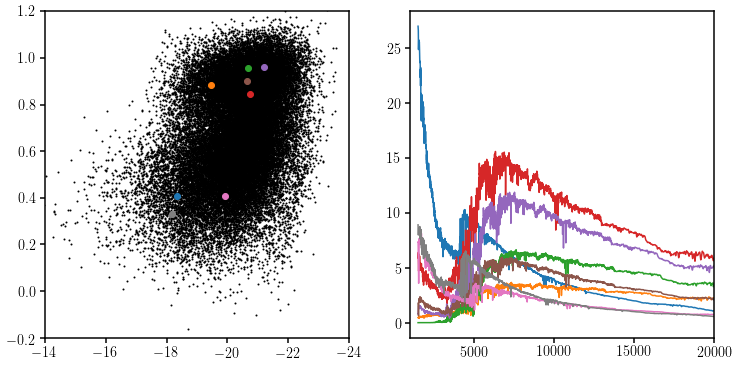

In [44]:
fig = plt.figure(figsize=(12,6))
sub1 = fig.add_subplot(121)
sub2 = fig.add_subplot(122)
sub1.scatter(mockdata['SDSS_absmag_r01'], mockdata['SDSS_01gr'], c='k', s=1)
for i in range(np.sum(keep)): 
    sub1.scatter([mockdata['SDSS_absmag_r01'][these][keep][i]], [mockdata['SDSS_01gr'][these][keep][i]])
    sub2.plot(BGSmaker.wave, flux[keep][i])
sub1.set_xlim([-14, -24])
sub1.set_ylim([-0.2, 1.2])
sub2.set_xlim([1000., 20000.])    